In [1]:
import torch
from torchvision import models
from PIL import Image
from torchvision import transforms
from PIL import Image
import requests
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
# Select MPS device
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")

In [3]:
print(torch.backends.mps.is_available())  # Should be True
print(torch.backends.mps.is_built())      # Should be True
print(device)  # Should output "mps"


True
True
cpu


## MODEL LOADING

In [4]:
# Load a pretrained DeepLabV3 model
# model = models.segmentation.deeplabv3_resnet50(weights="DEFAULT")

# Load Mask R-CNN model pretrained on COCO dataset
model = models.segmentation.fcn_resnet101(weights="DEFAULT")
model.eval()

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

## TEST SEGMENTATION ON TEST IMAGE

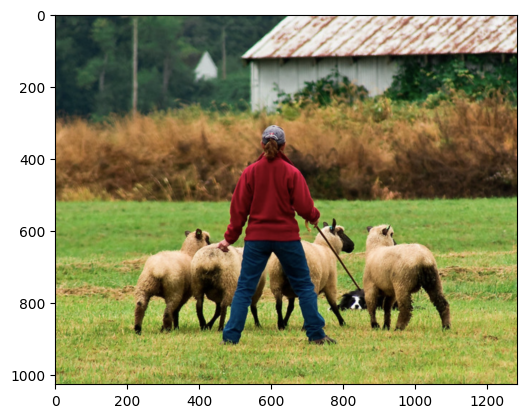

In [5]:
# Load an image and preprocess it
url = "https://raw.githubusercontent.com/pytorch/hub/master/images/deeplab1.png"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

plt.figure()
plt.imshow(image)

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((520, 520)),  # Resize image to 520x520
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = transform(image).unsqueeze(0).to(device)# Move to MPS

In [7]:
# Run inference
with torch.no_grad():
    output = model(input_tensor)["out"]

# Convert to segmentation mask
mask = output.argmax(1).byte().cpu().numpy()[0]  # Get class index for each pixel

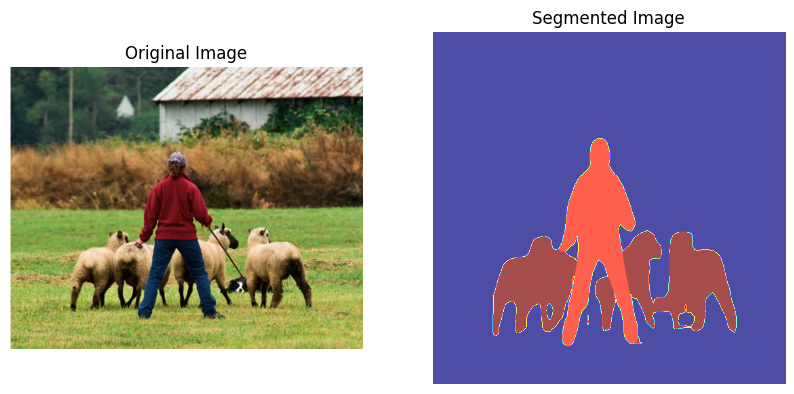

In [8]:
# Display the original image and the segmentation mask
plt.figure(figsize=(10, 5))

# Show original image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis("off")
plt.title("Original Image")

# Show segmentation mask
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="jet", alpha=0.7)  # Overlay segmentation map
plt.axis("off")
plt.title("Segmented Image")

plt.show()

In [ ]:
with torch.no_grad():
    predictions = model(input_tensor)

# Extract detections for the first image
boxes = predictions[0]["boxes"].cpu().numpy()  # Bounding boxes
labels = predictions[0]["labels"].cpu().numpy()  # Class labels
scores = predictions[0]["scores"].cpu().numpy()  # Confidence scores
masks = predictions[0]["masks"].cpu().numpy()  # Segmentation masks

# Set confidence threshold (e.g., keep predictions > 0.7 confidence)
threshold = 0.7
filtered_indices = [i for i, score in enumerate(scores) if score > threshold]

# Filter results
filtered_boxes = boxes[filtered_indices]
filtered_labels = labels[filtered_indices]
filtered_scores = scores[filtered_indices]
filtered_masks = masks[filtered_indices]

print(filtered_scores)


KeyError: 0

In [ ]:
# Convert image to OpenCV format
image_np = np.array(image)

# Draw bounding boxes and segmentation masks
for i, box in enumerate(filtered_boxes):
    x1, y1, x2, y2 = map(int, box)
    label = f"ID {filtered_labels[i]}: {filtered_scores[i]:.2f}"

    # Draw bounding box
    cv2.rectangle(image_np, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # Get segmentation mask and apply threshold
    mask = (filtered_masks[i] > 0.5).astype(np.uint8) * 255

    # Overlay segmentation mask
    # image_np[mask > 0] = [0, 255, 0]  # Green mask

    # Put label text
    cv2.putText(image_np, label, (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# Show the image with detections
plt.imshow(image_np)
plt.axis("off")
plt.show()

NameError: name 'filtered_boxes' is not defined

## LOAD VIDEO AND PREPROCESS

In [9]:
video_path = "videos/VID20250319095759.mp4"
cap = cv2.VideoCapture(video_path)

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(f"fps: {fps}, width: {frame_width}, height: {frame_height}")

fps: 30, width: 1920, height: 1080


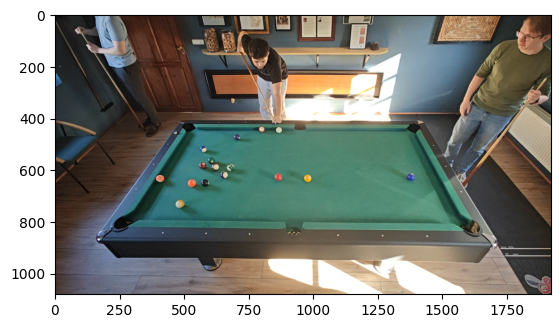

In [10]:
# Frame number to extract
frame_number = 1000

# Set the video position to the desired frame
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

ret, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame)

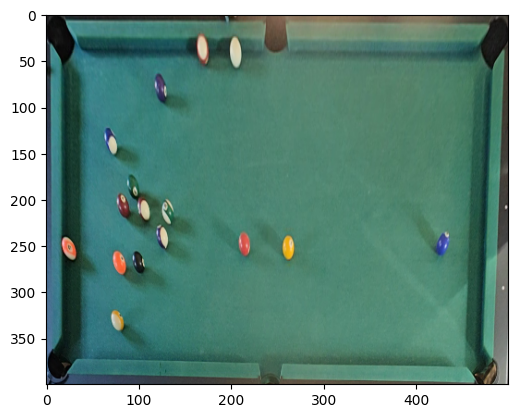

In [12]:
# Original table corner points in the image (change based on your video)
src_points = np.array([
    [500, 420],  # Top-left corner
    [1400, 420],  # Top-right corner
    [200, 840],  # Bottom-left corner
    [1690, 840]   # Bottom-right corner
], dtype=np.float32)

# Destination points for a "flattened" top-down view
dst_points = np.array([
    [0, 0],       # New top-left
    [500, 0],     # New top-right
    [0, 400],     # New bottom-left
    [500, 400]    # New bottom-right
], dtype=np.float32)

# Compute homography matrix
H, _ = cv2.findHomography(src_points, dst_points)

warped_frame = cv2.warpPerspective(frame, H, (500, 400))
plt.imshow(warped_frame)

(np.float64(-0.5), np.float64(499.5), np.float64(399.5), np.float64(-0.5))

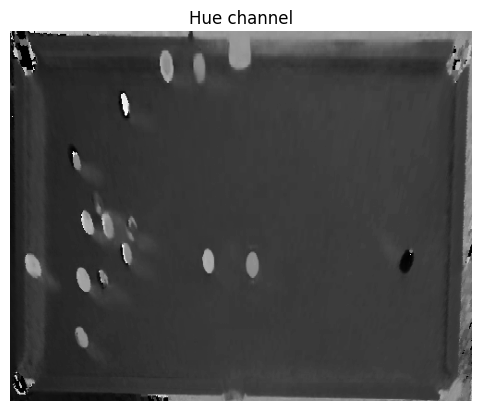

In [13]:
hsv = cv2.cvtColor(warped_frame, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv)

plt.figure()
plt.imshow(h, cmap="gray")
plt.title("Hue channel")
plt.axis('off')

<class 'numpy.ndarray'>
1
[[[1319.5       227.5        19.1     ]
  [1368.5       415.1        17.56    ]
  [ 156.09999   231.7        16.02    ]
  [ 725.89996   233.09999    12.94    ]
  [ 406.69998   220.5        17.56    ]
  [1375.5       427.69998    15.879999]
  [ 329.69998   251.3        14.06    ]
  [ 615.3        46.899998   10.28    ]
  [ 373.1       188.3        17.56    ]
  [ 426.3       189.7        14.06    ]
  [ 457.1        69.299995   19.1     ]
  [1381.1       177.09999    17.56    ]
  [ 353.5       168.7        16.02    ]
  [ 321.3       184.09999    15.879999]
  [1122.1       227.5        15.879999]
  [1322.2999    213.5        12.94    ]
  [ 234.5       332.5        17.42    ]
  [ 322.69998   121.1        12.66    ]
  [1329.2999    259.69998    12.94    ]
  [1137.5        38.5        17.42    ]
  [1350.2999    405.3        19.1     ]
  [ 546.7        44.1        18.96    ]
  [ 675.5       437.5        15.879999]
  [ 615.3        10.5        16.02    ]
  [1329.2999  

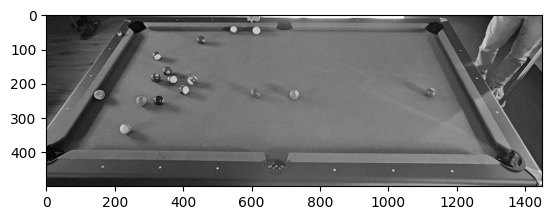

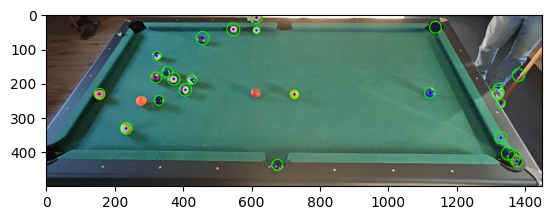

In [16]:
# Load the image
# image = warped_frame.copy()
frame2 = frame.copy()[400:900, 250:1700, :]

# Convert to grayscale
gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur to reduce noise
gray_blurred = cv2.GaussianBlur(gray, (9, 9), 3)
plt.figure()
plt.imshow(gray, cmap="gray")
# Detect circles using Hough Transform
circles = cv2.HoughCircles(
    gray_blurred, 
    cv2.HOUGH_GRADIENT, dp=1.4, minDist=10,
    param1=30, param2=20, minRadius=10, maxRadius=20
)
print(type(circles))
print(len(circles))
print(circles)

# Draw detected circles
if circles is not None:
    circles = np.uint16(np.around(circles))  # Convert to integers
    for i in circles[0, :]:
        cv2.circle(frame2, (i[0], i[1]), i[2], (0, 255, 0), 2)  # Draw circle
        cv2.circle(frame2, (i[0], i[1]), 2, (0, 0, 255), 3)  # Draw center

plt.figure()
plt.imshow(frame2)

400 500


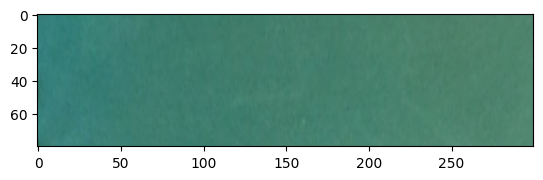

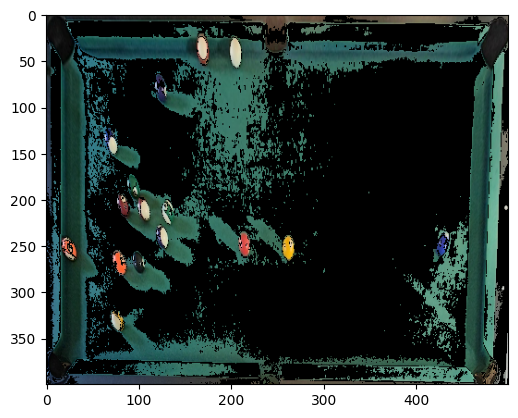

In [13]:
img = warped_frame.copy()
w, h = img.shape[:2]
print(w, h)

sub_img = img[110:190, 100:400]
plt.figure()
plt.imshow(sub_img)

median = np.mean(sub_img, axis=(0, 1))
median = np.full(img.shape, median, dtype=np.uint8)

diff = np.abs(img - median)
mask = np.any(diff < 20, axis=2)
img[mask] = 0

plt.figure()
plt.imshow(img)

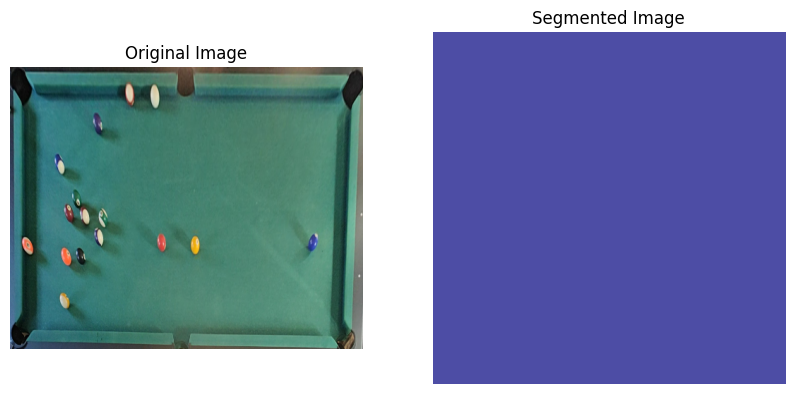

In [15]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((520, 520)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = transform(warped_frame).unsqueeze(0).to(device)  # Move to MPS

# Run inference
with torch.no_grad():
    output = model(input_tensor)["out"]

# Convert to segmentation mask
mask = output.argmax(1).byte().cpu().numpy()[0]  # Get class index for each pixel

# Display the original image and the segmentation mask
plt.figure(figsize=(10, 5))

# Show original image
plt.subplot(1, 2, 1)
plt.imshow(warped_frame)
plt.axis("off")
plt.title("Original Image")

# Show segmentation mask
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="jet", alpha=0.7)  # Overlay segmentation map
plt.axis("off")
plt.title("Segmented Image")

plt.show()

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((520, 520)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = transform(warped_frame).unsqueeze(0).to(device)  # Move to MPS

# Run inference
with torch.no_grad():
    predictions = model(input_tensor)

# Extract detections for the first image
boxes = predictions[0]["boxes"].cpu().numpy()  # Bounding boxes
labels = predictions[0]["labels"].cpu().numpy()  # Class labels
scores = predictions[0]["scores"].cpu().numpy()  # Confidence scores
print(scores)

threshold = 0.2
filtered_indices = [i for i, score in enumerate(scores) if score > threshold]

# Filter results
filtered_boxes = boxes[filtered_indices]
filtered_labels = labels[filtered_indices]
filtered_scores = scores[filtered_indices]

image_np = np.array(warped_frame)

# Draw bounding boxes
for i, box in enumerate(filtered_boxes):
    x1, y1, x2, y2 = map(int, box)
    label = f"ID {filtered_labels[i]}: {filtered_scores[i]:.2f}"

    # Draw rectangle
    cv2.rectangle(image_np, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # Put label text
    cv2.putText(image_np, label, (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# Show the image with detections
plt.imshow(image_np)
# plt.axis("off")
plt.show()

KeyError: 0

# BACKGROUND SUBTRACTION

In [61]:
# Load the video
video_path = "videos/VID20250319095759.mp4"
cap = cv2.VideoCapture(video_path)

# Define the green color range in HSV
lower_green = np.array([25, 40, 40])  # Adjust based on background
upper_green = np.array([95, 255, 255])

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to HSV
    frame = cv2.warpPerspective(frame, H, (500, 400))

    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Create mask to remove the green background
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Invert mask to keep only objects
    mask_inv = cv2.bitwise_not(mask)

    # Apply mask to get objects
    objects_only = cv2.bitwise_and(frame, frame, mask=mask_inv)

    # Convert to grayscale for contour detection
    gray = cv2.cvtColor(objects_only, cv2.COLOR_BGR2GRAY)

    # Threshold to get binary mask of objects
    _, thresh = cv2.threshold(gray, 20, 255, cv2.THRESH_BINARY)

    # Find contours of objects
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        # Get bounding box
        x, y, w, h = cv2.boundingRect(contour)

        if w > 50 or h > 50 or w < 10 or h < 10:
            continue

        # Compute centroid
        cx = int(x + w / 2)
        cy = int(y + h / 2)

        # Store the position
        # object_positions.append((cx, cy))

        # Draw the object and its centroid
        cv2.rectangle(objects_only, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.circle(objects_only, (cx, cy), 5, (0, 0, 255), -1)

    # Show the output
    cv2.imshow("Object Tracking", objects_only)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
import cv2
import numpy as np

# Load the video
video_path = "videos/VID20250319095759.mp4"
cap = cv2.VideoCapture(video_path)

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define output video writer
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter("output_video.mp4", fourcc, fps, (frame_width, frame_height))

# Create background subtractor
bg_subtractor = cv2.createBackgroundSubtractorMOG2(history=500000, varThreshold=50, detectShadows=True)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.warpPerspective(frame, H, (500, 400))

    # Apply background subtraction
    fg_mask = bg_subtractor.apply(frame)

    # Remove shadows (optional: convert to binary mask)
    _, mask = cv2.threshold(fg_mask, 250, 255, cv2.THRESH_BINARY)

    # Convert mask to 3 channels
    mask_3ch = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

    # Apply mask to remove background
    foreground = cv2.bitwise_and(frame, mask_3ch)

    gray = cv2.cvtColor(foreground, cv2.COLOR_BGR2GRAY)

    # Threshold to get binary mask of objects
    _, thresh = cv2.threshold(gray, 20, 255, cv2.THRESH_BINARY)

    # Find contours of objects
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        # Get bounding box
        x, y, w, h = cv2.boundingRect(contour)

        if w > 50 or h > 50 or w < 10 or h < 10:
            continue

        # Compute centroid
        cx = int(x + w / 2)
        cy = int(y + h / 2)

        # Store the position
        # object_positions.append((cx, cy))

        # Draw the object and its centroid
        cv2.rectangle(foreground, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.circle(foreground, (cx, cy), 5, (0, 0, 255), -1)


    # Save and display output frame
#    out.write(foreground)
    cv2.imshow("Foreground", mask_3ch)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()

print("Background removed and saved as output_video.mp4")

Background removed and saved as output_video.mp4


In [15]:
# Load the video
video_path = "videos/VID20250319095759.mp4"
cap = cv2.VideoCapture(video_path)

frame_count = 0
start_frame = 500
max_frames = 2000  # Set limit to first 1000 frames

frames = []
while cap.isOpened():
    if frame_count < start_frame:
        ret, frame = cap.read()
        frame_count += 1
        continue

    ret, frame = cap.read()
    if not ret or frame_count >= max_frames + start_frame:
        break  # Stop if video ends or 1000 frames are extracted

    frames.append(frame)
    frame_count += 1

cap.release()
print("Finished extracting frames. N: ", len(frames))

Finished extracting frames. N:  2000


In [16]:
warped_frames = []
for frame in frames:
    warped_frame = cv2.warpPerspective(frame, H, (500, 400))
    warped_frames.append(warped_frame)


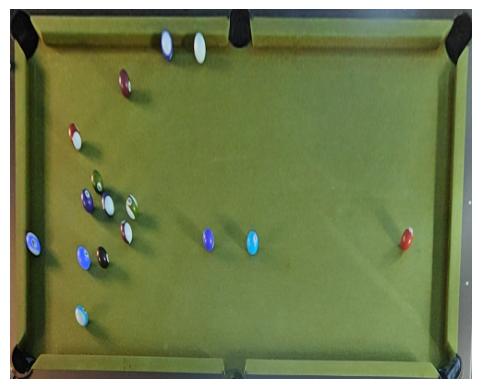

In [9]:
# Show the first frame
plt.imshow(warped_frames[100])
plt.axis("off")
plt.show()

(400, 500, 3)


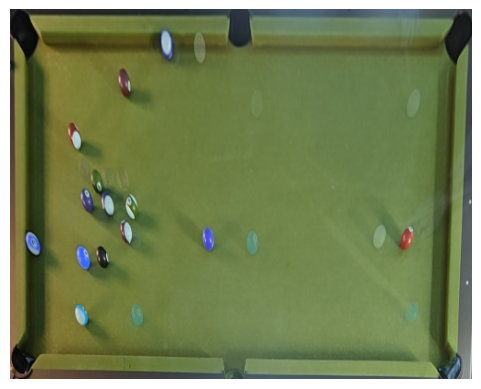

In [17]:
warped_frames = np.array(warped_frames)

# Get mean
mean_frame = np.mean(warped_frames, axis=0).astype(np.uint8)
print(mean_frame.shape)

# Show the mean frame
plt.imshow(mean_frame)
plt.axis("off")
plt.show()

In [19]:
# Make video where mean frame is subtracted from each frame
video_path = "videos/VID20250319095759.mp4"
cap = cv2.VideoCapture(video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    frame = cv2.warpPerspective(frame, H, (500, 400))
    frame = frame - mean_frame

    cv2.imshow("Foreground", frame)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Release resources
cap.release()

cv2.destroyAllWindows()


2025-03-19 17:31:42.048 python[19105:600548] _TIPropertyValueIsValid called with 16 on nil context!
2025-03-19 17:31:42.048 python[19105:600548] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-03-19 17:31:42.048 python[19105:600548] Text input context does not respond to _valueForTIProperty:
2025-03-19 17:31:42.327 python[19105:600548] _TIPropertyValueIsValid called with 16 on nil context!
2025-03-19 17:31:42.327 python[19105:600548] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-03-19 17:31:42.327 python[19105:600548] Text input context does not respond to _valueForTIProperty:


In [17]:
# Load the video
video_path = "videos/VID20250319095759.mp4"
cap = cv2.VideoCapture(video_path)

# Parameters for Shi-Tomasi corner detection
feature_params = dict(maxCorners=20, qualityLevel=0.2, minDistance=40, blockSize=5)

# Parameters for Lucas-Kanade Optical Flow
lk_params = dict(winSize=(15, 15), maxLevel=3,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 20, 0.1))

# Read the first frame
for _ in range(500):
    ret, old_frame = cap.read()

old_frame = cv2.warpPerspective(frame, H, (500, 400))
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

# Detect feature points
p0 = cv2.goodFeaturesToTrack(old_gray, maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)
if p0 is None:
    p0 = []

# Create mask for drawing motion trails
mask = np.zeros_like(old_frame)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.warpPerspective(frame, H, (500, 400))
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    if p0 is None or len(p0) == 0:
        print("Re-detecting key points...")
        p0 = cv2.goodFeaturesToTrack(frame_gray, mask=None, **feature_params)
        if p0 is None:
            print("No key points found, skipping this frame.")
            continue  # Skip this frame

    # Calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Select good points
    good_new = p1[st == 1]
    good_old = p0[st == 1]

    # Draw motion trails
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        cv2.line(mask, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
        cv2.circle(frame, (int(a), int(b)), 5, (0, 0, 255), -1)

    # Overlay trails on the frame
    output = cv2.add(frame, mask)

    # Update for next iteration
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

    cv2.imshow("Optical Flow - Lucas Kanade", output)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

2025-03-20 09:03:20.688 python[71169:884310] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-20 09:03:20.688 python[71169:884310] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Re-detecting key points...


In [ ]:
# Load video
video_path = "videos/VID20250319095759.mp4"
cap = cv2.VideoCapture(video_path)

# Read the first frame
ret, prev_frame = cap.read()
if not ret:
    print("Error: Couldn't read video file")
    cap.release()
    exit()

# Convert to grayscale
prev_frame = cv2.warpPerspective(prev_frame, H, (500, 400))
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

# Create an HSV image to visualize motion
hsv = np.zeros_like(prev_frame)
hsv[..., 1] = 255  # Set saturation to max

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.warpPerspective(frame, H, (500, 400))

    # Convert current frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Compute Dense Optical Flow (Farneback method)
    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 
                                        pyr_scale=0.5, levels=3, winsize=15, 
                                        iterations=10, poly_n=5, poly_sigma=1.2, flags=0)

    # Convert flow to HSV representation
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  # Get magnitude and angle
    hsv[..., 0] = ang * 180 / np.pi / 2  # Convert angle to degrees for hue
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)  # Normalize magnitude

    # Convert HSV to BGR to display motion field
    flow_bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # Show the Optical Flow result
    cv2.imshow("Dense Optical Flow (Farneback)", flow_bgr)

    # Update previous frame
    prev_gray = gray.copy()

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()


2025-03-20 09:07:14.032 python[71169:884310] _TIPropertyValueIsValid called with 16 on nil context!
2025-03-20 09:07:14.032 python[71169:884310] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-03-20 09:07:14.032 python[71169:884310] Text input context does not respond to _valueForTIProperty:
2025-03-20 09:07:20.939 python[71169:884310] _TIPropertyValueIsValid called with 16 on nil context!
2025-03-20 09:07:20.939 python[71169:884310] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-03-20 09:07:20.939 python[71169:884310] Text input context does not respond to _valueForTIProperty:


In [19]:
# Load video
video_path = "videos/VID20250319095759.mp4"
cap = cv2.VideoCapture(video_path)

# Parameters for Lucas-Kanade Optical Flow
lk_params = dict(winSize=(15, 15), maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Read the first frame
for _ in range(500):
    ret, old_frame = cap.read()
if not ret:
    print("Error: Couldn't read video file")
    cap.release()
    exit()

# Convert first frame to grayscale
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
old_gray = cv2.warpPerspective(old_gray, H, (500, 400))

# Detect circles in the first frame
circles = cv2.HoughCircles(old_gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=30,
                           param1=20, param2=20, minRadius=10, maxRadius=100)

# Ensure circles were found
if circles is not None:
    circles = np.uint16(np.around(circles))  # Convert to integer
    p0 = np.array([[c[0], c[1]] for c in circles[0]], dtype=np.float32).reshape(-1, 1, 2)  # Use circle centers
else:
    print("No circles detected in first frame!")
    cap.release()
    exit()

# Create a mask for drawing motion trails
mask = np.zeros_like(old_gray)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.warpPerspective(frame, H, (500, 400))
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Compute Optical Flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Select good points
    if p1 is not None:
        good_new = p1[st == 1]
        good_old = p0[st == 1]

        # Draw motion trails
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            cv2.line(mask, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
            cv2.circle(frame, (int(a), int(b)), 10, (0, 0, 255), -1)  # Draw circle center

        # Update old values
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1, 1, 2)

    # Overlay trails on frame
    output = cv2.add(frame_gray, mask)
    cv2.imshow("Circle Tracking", output)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()